In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [10]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader
from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
first_time_running = True
load_model = False
seed = 42

ae_loss = 'chamfer'

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
experiment_name = 'ae_gan_'+ class_name +'_' + str(n_pc_samples) +  '_pts'

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'

train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/ae_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

Give me the class type.
chair


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_gan_chair_2048_pts'

In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )

6778 files containing complete point clouds were found.


In [6]:
# Load Auto-Encoder
reset_tf_graph()
ae_net_name = '1_three_fc_dec_with_spn_' + str(n_pc_samples) +  'pts_' + ae_loss
ae_net_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae', ae_net_name)
ae_conf = Conf.load(osp.join(ae_net_dir, 'configuration'))
ae = PointNetAutoEncoder(ae_net_name, ae_conf)
saved_epochs = read_saved_epochs(ae_conf.train_dir)
last_epoch = saved_epochs[-1]
ae.restore_model(ae_conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1000.


In [7]:
# Convert raw-data to latent codes.
raw_data = PointCloudDataSet(pclouds, init_shuffle=False)
_, latent_codes, _ = latent_embedding_of_entire_dataset(raw_data, ae, ae_conf)
training_data = PointCloudDataSet(latent_codes)

In [8]:
reset_tf_graph()
init_lr = 0.001
n_out = latent_codes.shape[1]
gan = LatentGAN(experiment_name, learning_rate=init_lr, n_output=[n_out])

In [9]:
from tf_lab.point_clouds.gan import model_saver_id

train_stats = []
batch_size = 50
max_epochs = 100
noise_params = {'mu':0, 'sigma': 1}

for _ in range(max_epochs):
    checkpoint_path = osp.join(train_dir, model_saver_id)
    loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params)
    epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
    print epoch, loss
    gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
    train_stats.append((epoch,) + loss)

1 (0.62925016681353252, 5.3518418848514555)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_gan_chair_2048_pts/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (1.1324209535563434, 2.2920446733633679)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_gan_chair_2048_pts/models.ckpt-2 is not in all_model_checkpoint_paths. Manually adding it.
3 (1.183179697725508, 1.7552399932234375)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_gan_chair_2048_pts/models.ckpt-3 is not in all_model_checkpoint_paths. Manually adding it.
4 (1.2683424755379005, 1.3422226922379599)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/gan/ae_gan/ae_gan_chair_2048_pts/models.ckpt-4 is not in all_model_checkpoint_paths. Manually adding it.
5 (1.2983585075095847, 1.2323504421446059)
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/D

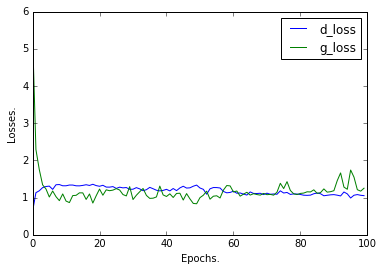

In [19]:
train_stats[0]
x = range(len(train_stats))
d_loss = [t[1] for t in train_stats]
g_loss = [t[2] for t in train_stats]
plt.plot(x, d_loss)
plt.plot(x, g_loss)
plt.legend(['d_loss', 'g_loss'], loc=0)
plt.xlabel('Epochs.')
plt.ylabel('Losses.')

In [35]:
# Swap axis and save
n_samples = 1000
syn_data = gan.generate(n_samples, noise_params)
syn_data = ae.decode(syn_data)

syn_data_rot = np.empty_like(syn_data)
for i, pc in enumerate(syn_data):
    syn_data_rot[i] = pc[:, [0, 2, 1]]
    pc = Point_Cloud(syn_data_rot[i]).center_in_unit_sphere()
    syn_data_rot[i] = pc.points

save_out = osp.join(synthetic_data_out_dir, experiment_name + '_epoch_' + str(epoch))
np.savez(save_out, syn_data_rot)

In [32]:
entropy_of_occupancy_grid(syn_data, 32)

0.058052615905933927

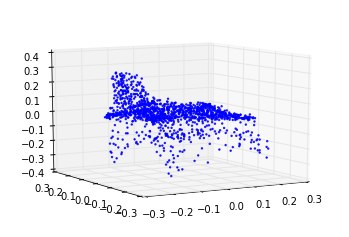

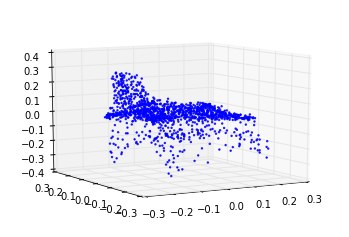

In [33]:
Point_Cloud(syn_data[20]).plot()